In [2]:
import pandas as pd

df = pd.read_csv("/Users/ashe/Desktop/credit-default-project/UCI_Credit_Card.csv")

# Inspect
df.head()
df.info()
df.describe()
df.isnull().sum()  # missing values
df.duplicated().sum()  # duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

np.int64(0)

2. clean and preprocess

In [3]:

df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

#id is confusing and not needed for this analysis
df.drop(columns=['ID'], inplace=True)


categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
for col in categorical_cols:
    df[col] = df[col].astype('category')


for col in categorical_cols:
    print(f"{col} unique values: {df[col].unique()}")

print("Missing values per column:\n", df.isnull().sum())

print("Target distribution:\n", df['default'].value_counts(normalize=True))

SEX unique values: [2, 1]
Categories (2, int64): [1, 2]
EDUCATION unique values: [2, 1, 3, 5, 4, 6, 0]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]
MARRIAGE unique values: [1, 2, 3, 0]
Categories (4, int64): [0, 1, 2, 3]
Missing values per column:
 LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64
Target distribution:
 default
0    0.7788
1    0.2212
Name: proportion, dtype: float64


from this we learned:

SEX: 1 is male, 2 is female

~22% defaults -> imbalanced so we should focusing on recall/F1


EDA:

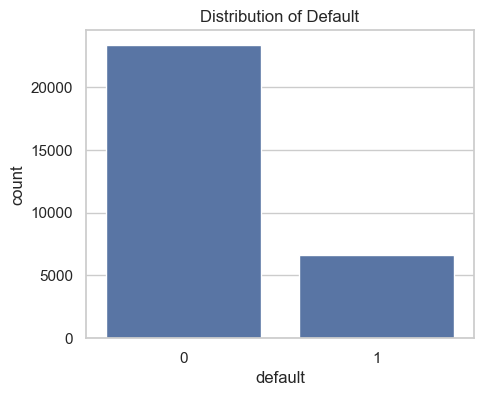

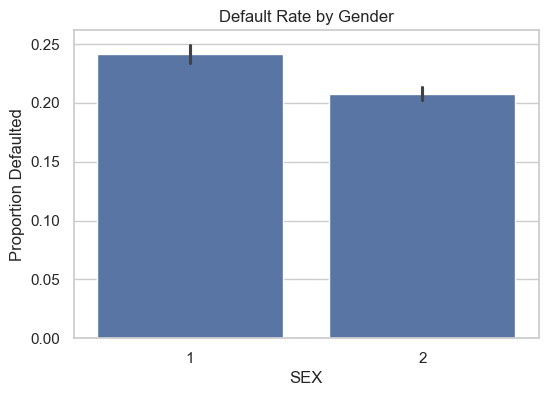

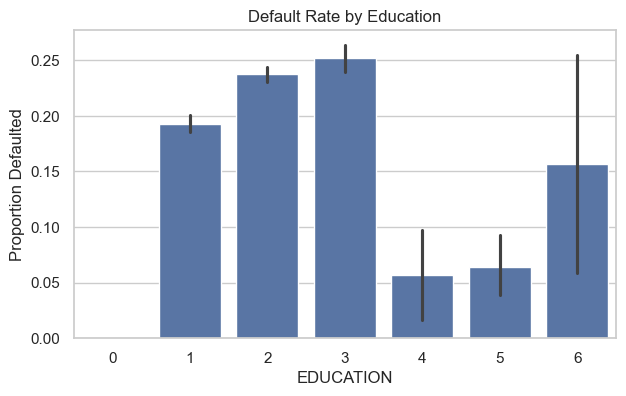

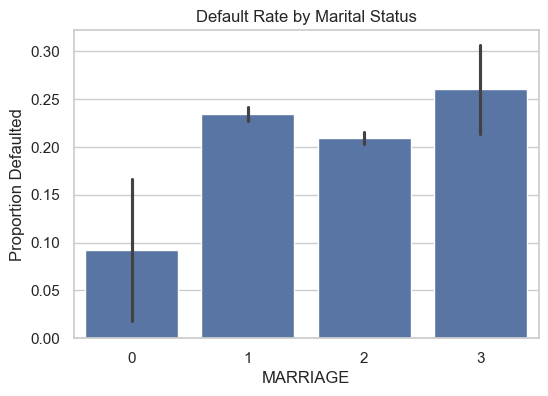

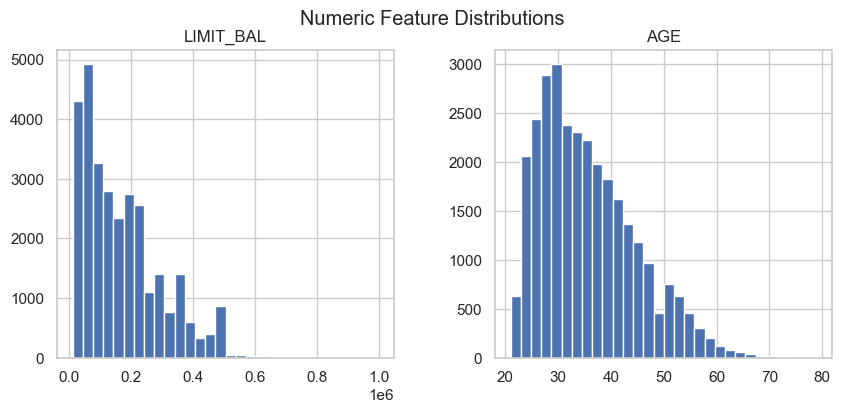

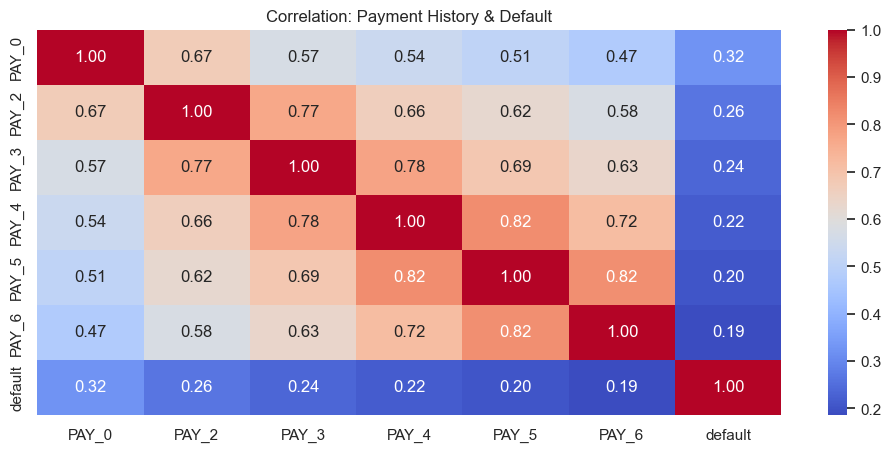

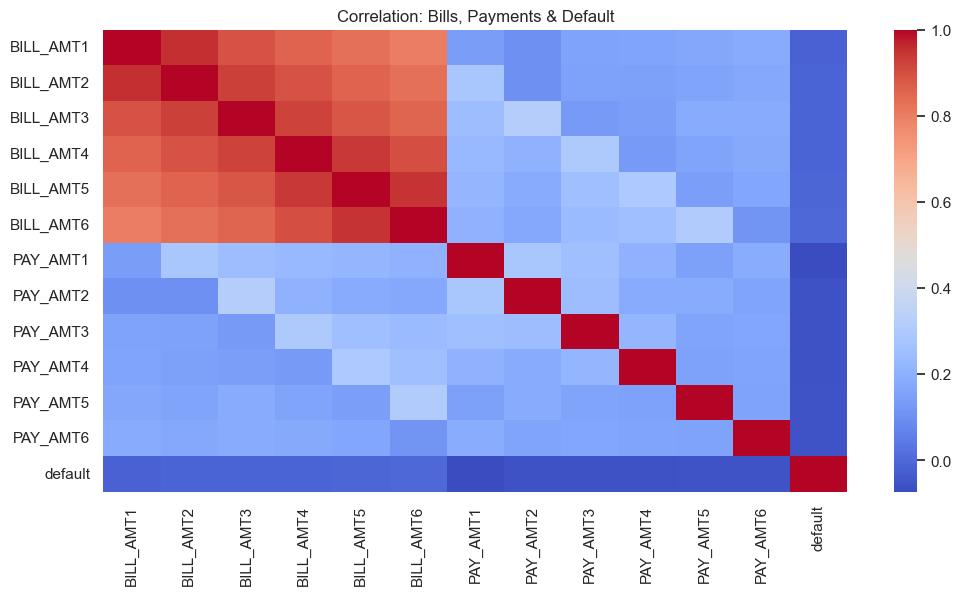

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(5,4))
sns.countplot(x='default', data=df)
plt.title('Distribution of Default')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='SEX', y='default', data=df, estimator=lambda x: sum(x)/len(x))
plt.title('Default Rate by Gender')
plt.ylabel('Proportion Defaulted')
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(x='EDUCATION', y='default', data=df, estimator=lambda x: sum(x)/len(x))
plt.title('Default Rate by Education')
plt.ylabel('Proportion Defaulted')
plt.show()


plt.figure(figsize=(6,4))
sns.barplot(x='MARRIAGE', y='default', data=df, estimator=lambda x: sum(x)/len(x))
plt.title('Default Rate by Marital Status')
plt.ylabel('Proportion Defaulted')
plt.show()


numeric_cols = ['LIMIT_BAL','AGE']
df[numeric_cols].hist(bins=30, figsize=(10,4))
plt.suptitle('Numeric Feature Distributions')
plt.show()

pay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
plt.figure(figsize=(12,5))
sns.heatmap(df[pay_cols + ['default']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation: Payment History & Default')
plt.show()

bill_pay_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                 'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
plt.figure(figsize=(12,6))
sns.heatmap(df[bill_pay_cols + ['default']].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation: Bills, Payments & Default')
plt.show()

Feature Engineering/ Train-test split

In [5]:
from sklearn.model_selection import train_test_split

pay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
df['max_delay'] = df[pay_cols].max(axis=1)          
df['avg_delay'] = df[pay_cols].mean(axis=1)        

bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_amt_cols = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

df['total_bill'] = df[bill_cols].sum(axis=1)
df['total_payment'] = df[pay_amt_cols].sum(axis=1)
df['avg_bill'] = df[bill_cols].mean(axis=1)
df['avg_payment'] = df[pay_amt_cols].mean(axis=1)

for b,p in zip(bill_cols, pay_amt_cols):
    df[f'{p}_ratio'] = df[p] / (df[b] + 1) #no divide by 0

df_encoded = pd.get_dummies(df, columns=['SEX','EDUCATION','MARRIAGE'], drop_first=True)

X = df_encoded.drop(columns=['default'])
y = df_encoded['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Target distribution in training set:\n", y_train.value_counts(normalize=True))

Training set shape: (24000, 42)
Test set shape: (6000, 42)
Target distribution in training set:
 default
0    0.778792
1    0.221208
Name: proportion, dtype: float64


Since we have an imbalance we are gonna focus on: Logistic Regression, Random Forest, and XGBoost, and evaluate using recall, precision, F1-score, and ROC-AUC

Any NaNs left in X? 0


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.50      0.63      4673
           1       0.29      0.70      0.41      1327

    accuracy                           0.55      6000
   macro avg       0.57      0.60      0.52      6000
weighted avg       0.73      0.55      0.58      6000

ROC-AUC: 0.6415690128366536

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

ROC-AUC: 0.7576848418603818

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4673
           1       0.48      0.53      0.50      1327

    accuracy                           0.77      6000
   m

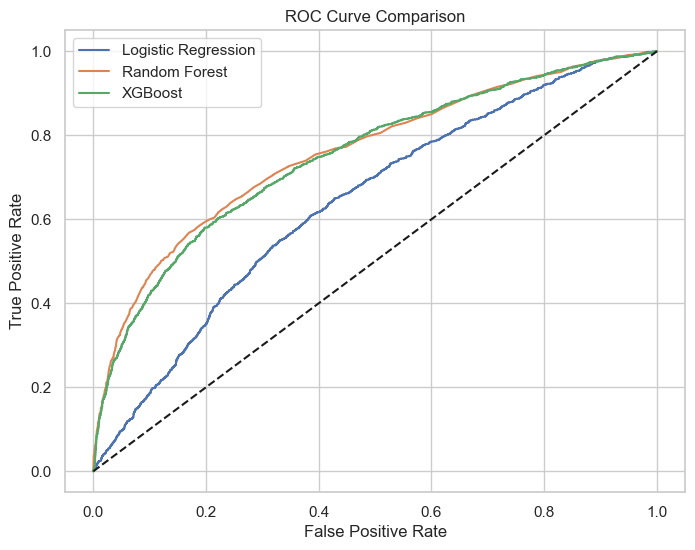

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Fix NaNs and infs in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print("Any NaNs left in X?", X.isnull().sum().sum())

# 🔁 Re-split AFTER cleaning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

xgb_model = xgb.XGBClassifier(n_estimators=200, scale_pos_weight=(len(y_train[y_train==0])/len(y_train[y_train==1])), 
                              random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("\n=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

LR: Output of this is agressive. It flags alot of customers as risky
    - Use case would be an early warning system

Random Forest: it only flags customers when it confident
    - Use case would be like credit increases 

XGBoost: the most balanced of the three